In [94]:
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
def f(x):
    return 3*x**2 - 4*x + 5

In [96]:
f(3.0)

20.0

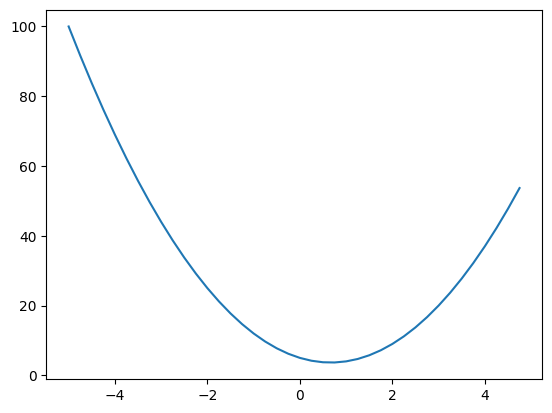

In [97]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [98]:
h = 0.0001
x = 2/3
(f(x+h)-f(x))/h


0.0002999999981767587

In [99]:
#lets get into more complex 
a = 2.0 
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [100]:
h = 0.0001
#inputs
a = 2.0 
b = -3.0
c = 10.0
d1 = a*b + c

#increase "a" slightly
b += h
d2 = a*b + c
print("d1 = ", d1)
print("d2 = ", d2)
print("slope = ", (d2 - d1)/h)

d1 =  4.0
d2 =  4.0002
slope =  2.0000000000042206


In [103]:
import math

class Value:
  
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (other * -1)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * (self.data**(other-1))) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
# Creating some Value objects
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Testing addition and multiplication
print(a + b)   # calls a.__add__(b)
print(a * b)   # calls a.__mul__(b)

# More complex computation
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'

f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

# Final output
print(L)

Value(data=-1.0)
Value(data=-6.0)
Value(data=-8.0)


In [104]:
display(d._prev)
display(d._op)

{Value(data=-6.0), Value(data=10.0)}

'+'

In [105]:
#let's visualize the operations above - using the api called Graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

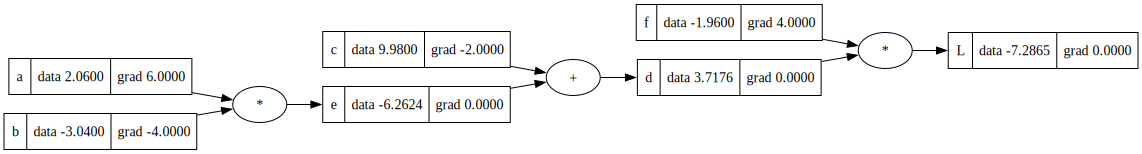

In [109]:
draw_dot(L) #this process is called forward pass 

In [107]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [108]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad 
f.data += 0.01 * f.grad 

e = a*b; e.label = 'e'
d = e + c; d.label ='d'
L = d*f; L.label = 'L'

print(L)

Value(data=-7.286496)


In [110]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label ='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label ='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data +=h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = (e + c); d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)
lol()

-3.9999999999995595


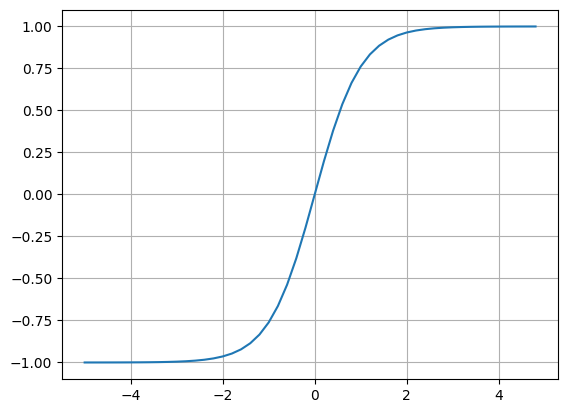

In [111]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [112]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

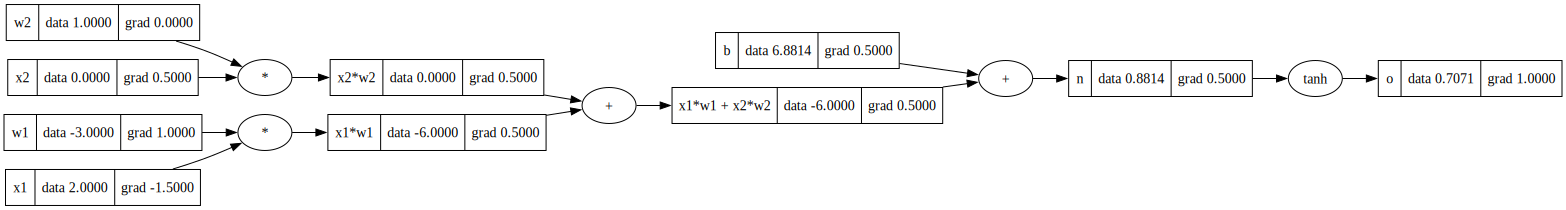

In [115]:
draw_dot(o)

In [114]:
o.backward()

In [116]:
#topological order of keeping the nodes 
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [35]:
#Backpropogation using backward() function
o.grad = 1.0
o._backward()

In [39]:
n._backward()

In [41]:
x1w1x2w2._backward()

In [43]:
x2w2._backward()
x1w1._backward()

In [159]:
# Doing Back propogation for the above neural network
# o = tanh(n)
# do/dn = 1 - o**2
o.grad = 1.0
n. grad = 1 - o.data**2
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [117]:
#The same above Mathematical expressions will be implemented by the Pytorch lib using tensors insted of scalars.
import torch
import random

In [118]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [125]:
#Build a 1. single neuron 2. A Layer 3. Multilayer Perceptron.
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
      
x = [Value(2.0), Value(3.0), Value(-1.0)]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.954702054245357)

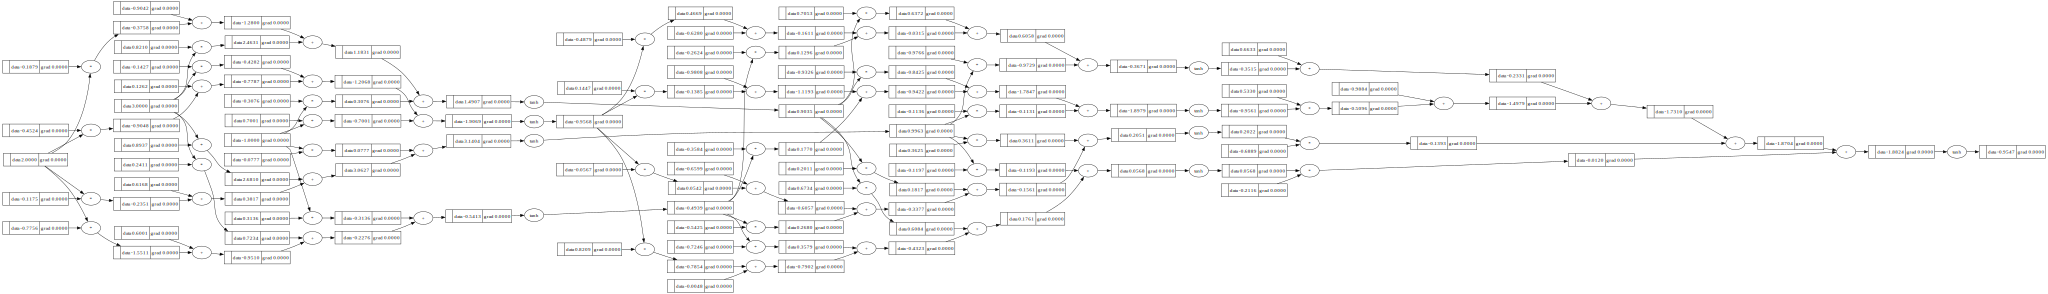

In [126]:
draw_dot(n(x))

In [121]:
#creating a very simple dataset to understand the loss function
xs = [
  [Value(2.0), Value(3.0), Value(-1.0)],
  [Value(3.0), Value(-1.0), Value(0.5)],
  [Value(0.5),Value (1.0),Value (1.0)],
  [Value(1.0), Value(1.0),Value (-1.0)],
]
ys = [Value(1.0), Value(-1.0), Value(-1.0), Value(1.0)] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7696781152242507),
 Value(data=0.7407939734477561),
 Value(data=0.6952365339058199),
 Value(data=0.8070900791151443)]

In [129]:
for k in range(20):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0.0)) # mean squared loss
  
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
  
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
  
    print(k, loss.data)

0 0.024854001922739448
1 0.023245173194121192
2 0.0218223441579939
3 0.020555520605543873
4 0.01942078051428105
5 0.01839881805958237
6 0.017473886235297872
7 0.01663301656852848
8 0.015865434922237402
9 0.015162118320184869
10 0.014515454694011375
11 0.013918978761949457
12 0.013367164920847878
13 0.01285526332183388
14 0.012379168999611752
15 0.011935316548943004
16 0.011520594725860405
17 0.011132276720016593
18 0.010767962850016747
19 0.010425533179653166


In [130]:
ypred

[Value(data=0.9621638477605717),
 Value(data=-0.9872771660505119),
 Value(data=-0.9291551288063559),
 Value(data=0.9382497572051923)]

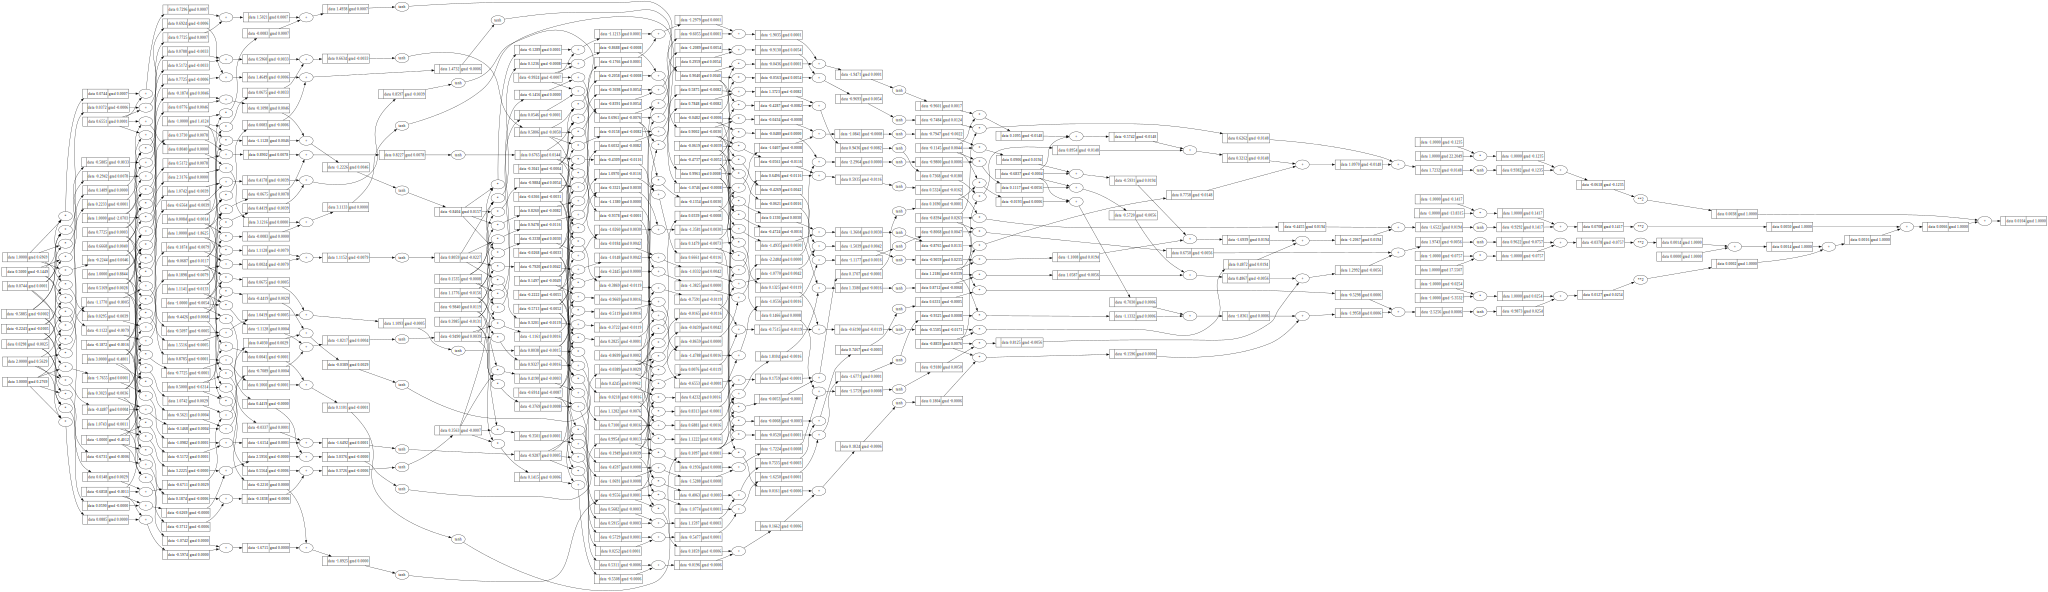

In [131]:
draw_dot(loss) #ultimate from scratch gradient descent intergrated neural network.